# US Mortality Rates: Trends and Policy Implications

#### Sriman Kolachalam
#### Prathamesh Desai

## Problem Domain

#### In the below code, we explore macro- and micro-level trends in mortality rates in the United States. Using data provided by the Institute for Health Metrics and Evaluation, we analyze trends in mortality rates from 21 disease/medical condition categories (ex. Cardiovascular disease, Diabetes, Respiratory disease) from 1980 to 2014. For a more detailed look at all the diseases studied, please see the attached original data file mort.xlsx. For a video walkthrough, you can see the file Video_link.txt for a link to a youtube video.

#### NOTE: All mortality rates are per 100,000 population. Ex. A mortality rate of 100 indicates that on average 100 people die from this disease per 100,000 people in the affected area.

## Key Questions

#### The key questions we answer are the following: 
#### 1. How have mortality rates changed over time? Which diseases' mortality rates have fallen in the last 34 years? Which have remained the same or gotten worse?
#### 2. Are mortality rates due to various diseases consistent across the United States? What about within states?
#### 3. What insights/value can this sort of analysis drive for policy-makers?

## Summary of Findings

#### Overall, mortality rates, not surpirsingly, have fallen in the last 34 years. this can be attritbuted to a variety of factors, some of which include improvements in medicine and technology which have allowed for better preventative care and care in the event someone has a life-threatening condition. However, what might not be so obvious is the composition of this decline: it is not that we all mortality rates have steadily fallen, but rather that we have gotten much better at tackling certain diseases, while others still plague us. Specifically, Cardiovascular disease-related mortality rates have fallen by over 40% in the past 34 years; as the deadliest disease over this time frame, such a drop in mortality rates is nothing short of a success story. However, there are other diseases whose impact is as far reaching as cardiovascular disease - such as Mental Health and Substance Abuse - whose mortality rates have gotten worse during this same 34 year time frame.

#### A deeper analysis of mortality rates across states sheds light on the fact that diseases impact states very differently. Furthermore, at a more fine level of analysis, when we look within states, we find there is signficant heterogeneity among counties within a state in terms of mortality rates. The same disease can be very deadly in one county within a state, yet be under control in other counties within that same state. These findings suggest that analysis of county-level variation within states is important in diagnosing and dealing with curbing mortality rates. While there is much policy focus at the federal level to combat healthcare issues such as this one, our findings suggest taking a more micro approach to healthcare policy may also be of interest to policy makers. With such startling variation in mortality within states, it is logical to consider healthcare policy geared more towards the local/county level.

## Approach
#### In the sections below, we walk through our approach to tackling the above questions and how we end up at the recommendations provided above. We begin with the initial data preprocessing which was required to transform the data into the various slices we needed for our analysis. We then walk through the exploratory analysis, detailing what we find and it's implications. Additional vizualizations and the neccesary .csv files needed to re-create them can be found in the attached tableau workbooks and .csv files.

## Data Preprocessing
#### In this section, we perform all necessary data cleaning and transformation to carry out our analysis.

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
import plotly.graph_objects as go   # need to install plotly using: conda install -c plotly plotly=4.1.0
from IPython.display import Image
from IPython.display import Video
from IPython.display import HTML

In [2]:
## Read in data
def read_data(infile, sheet, skip_rows = [0], n_rows = 3194):
    '''
    Read in mortality rate data and convert to dataframe
    '''
    df = pd.read_excel(infile, 
                       sheet_name = sheet, 
                       skiprows = skip_rows,      # skip first row (it is not a data row)
                       nrows = n_rows)        # only go up to last data row we care about
    return df

In [3]:
def only_state_level_data(df):
    '''
    Get only US-level data and state_level data
    '''
    df = df[(df.FIPS < 57) | (df.FIPS.isna())]

    ## Reset index of dataframe
    df.reset_index(inplace = True)
    df.drop(['index'], axis = 1, inplace = True)
    
    return df

In [4]:
def only_county_level_data(df):
    '''
    Remove US-level and state-level rows to work only with county-level data
    '''
    df = df[df.FIPS > 57]
    
    ## Reset index of dataframe
    df.reset_index(inplace = True)
    df.drop(['index'], axis = 1, inplace = True)
    
    return df

In [5]:
def add_cause_of_death_col(df, cause_of_death, col_name = 'Cause_of_death'):
    '''
    Add a column indicating the disease/condition name
    '''
    df.insert(loc = 0, column = col_name, value = cause_of_death)  
    return df

In [6]:
def clean_col_data(df):
    '''
    Get only average mortality rate (removing 95% confidence band around measured numbers)
    '''
    cols = list(df.iloc[:, 3:].columns)    # get names of columns to clean data on
    for col in cols:
        df[col] = df[col].str.split().str[0]   # remove (...) stuff from each column        
    return df

In [7]:
def transpose_data(df, years = [1985, 1990, 1995, 2000, 2005, 2010, 2014]):
    '''
    Tranpose yearly column data into rows
    '''
    updated_col_names = {'Mortality Rate, 1980*': 'Mortality_rate', 'Mortality Rate, 1985*': 'Mortality_rate', 
                         'Mortality Rate, 1990*': 'Mortality_rate', 'Mortality Rate, 1995*': 'Mortality_rate', 
                         'Mortality Rate, 2000*': 'Mortality_rate', 'Mortality Rate, 2005*': 'Mortality_rate',
                         'Mortality Rate, 2010*': 'Mortality_rate', 'Mortality Rate, 2014*': 'Mortality_rate'}

    df.rename(columns = updated_col_names, inplace = True) 
    df = df.iloc[:, :-1]      # remove last column (% change column)

    ## Setup for first column with 1980 data
    df.insert(loc = 3, column = 'Year', value = 1980)
    #df

    temp = df.iloc[:, [0, 1, 2, 3, 4]]
    temp

    col_nums_to_transpose = [i for i in range(5, 12)]   # 7 year columns worth of data we need to transpose

    ## Tranpose year columns' data and append to a new dataframe
    for i in range(len(col_nums_to_transpose)):
        data_to_append = df.iloc[:, [0, 1, 2, 3, col_nums_to_transpose[i]]]   # get year of data to append
        data_to_append['Year'] = years[i]         # change year 
        temp = pd.concat([temp, data_to_append], axis=0)
    temp.reset_index(drop = True, inplace = True)
    
    return temp

In [8]:
def final_df():
    '''
    Create clean dataframes for each sheet of data, and append together to get final dataframe
    '''
    ## Initialize empty dataframes to store data for all causes of death
    state_mortality_df = pd.DataFrame()
    county_mortality_df = pd.DataFrame()
    state_mortality_pct_change = pd.DataFrame()
    county_mortality_pct_change = pd.DataFrame()
    
    ## Append each sheet to state and county dataframes
    for sheet_name in sheet_names:
        df = read_data(infile = mortality_file, sheet = sheet_name, skip_rows = [0], n_rows = 3194)

        ## Get 1) US-level data and state-level data and 2) county-level data
        df_state_clean = only_state_level_data(df)
        df_county_clean = only_county_level_data(df)

        ## Add a column indicating the disease/condition name
        df_state_clean2 = add_cause_of_death_col(df_state_clean, 
                                                 cause_of_death = sheet_name, 
                                                 col_name = 'Cause_of_death')
        df_county_clean2 = add_cause_of_death_col(df_county_clean,
                                                  cause_of_death = sheet_name,
                                                  col_name = 'Cause_of_death')

        ## Get only average mortality rate (removing 95% confidence band around measured numbers)
        df_state_clean3 = clean_col_data(df_state_clean2)
        df_county_clean3 = clean_col_data(df_county_clean2)
        
        ## Get cleaned final result dataframes for mortality rates for each year
        df_state_final = transpose_data(df_state_clean3)
        df_county_final = transpose_data(df_county_clean3)      
        state_mortality_df = pd.concat([state_mortality_df, df_state_final], axis = 0)
        county_mortality_df = pd.concat([county_mortality_df, df_county_final], axis = 0)

        ## Get cleaned final result dataframes looking only at % change mortality rates from 1980-2014
        state_mortality_pct_change = pd.concat([state_mortality_pct_change, 
                                                df_state_clean3.iloc[:, [0, 1, 2, 11]]], 
                                                axis = 0)
        county_mortality_pct_change = pd.concat([county_mortality_pct_change, 
                                                 df_county_clean3.iloc[:, [0, 1, 2, 11]]], 
                                                 axis = 0)
        
    state_mortality_df.reset_index(drop = True, inplace = True)
    county_mortality_df.reset_index(drop = True, inplace = True)
    state_mortality_pct_change.reset_index(drop = True, inplace = True)
    county_mortality_pct_change.reset_index(drop = True, inplace = True)
    
    return state_mortality_df, county_mortality_df, state_mortality_pct_change, county_mortality_pct_change

## Exploratory Analysis
#### In this section, we walk through the various stages of our EDA process, discuss our findings, and explain how we took the path we did.

In [9]:
## Read in cleaned state_level mortality data
mort = pd.read_csv('state_mortality_clean.csv')
mort.head()

## Add state codes to mortality data for mapping
state_codes = pd.read_csv('state_codes.csv')   # get state codes for mapping
state_mort = pd.merge(left = mort, right = state_codes, 
                      left_on = 'Location', 
                      right_on = 'state').iloc[:, :-1]  # get only state data (drop rows with US level data)
state_mort;

#### In the below chunk, we explore trends in mortality rates from the Top 5 deadliest diseases as of 1980; these diseases are also the Top 5 as of 2014. From the graph, we can see that the decline in mortality rates is primarily attributable to the decline in the US's deadliest disease: Cardiovascular diseases. Mortality rates for Cardiovascular diseases have fallen by over 40% since 1980.  

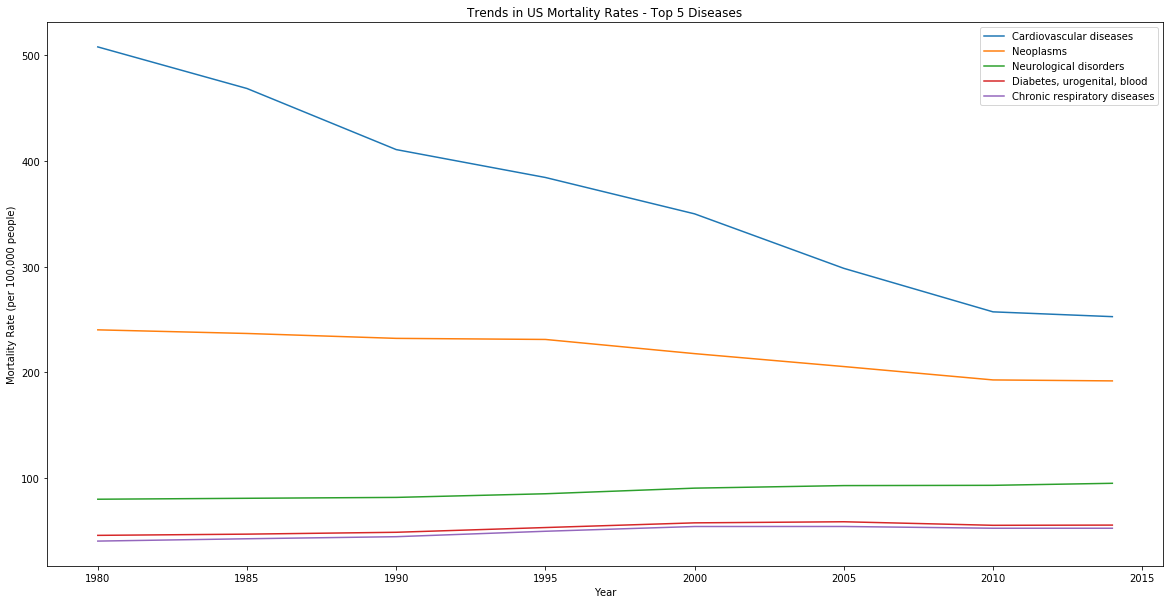

In [10]:
## Plot trend in mortality rates in the US for Top 5 deadliest diseases/conditions 
US_mort = mort[mort.Location == 'United States'].sort_values(['Cause_of_death', 'Year']).reset_index(drop = True)

US_mort_cardio = US_mort[(US_mort.Cause_of_death == 'Cardiovascular diseases')].reset_index(drop = True)
US_mort_neo = US_mort[(US_mort.Cause_of_death == 'Neoplasms')].reset_index(drop = True)
US_mort_neuro = US_mort[(US_mort.Cause_of_death == 'Neurological disorders')].reset_index(drop = True)
US_mort_diabet = US_mort[(US_mort.Cause_of_death == 'Diabetes, urogenital, blood')].reset_index(drop = True)
US_mort_resp = US_mort[(US_mort.Cause_of_death == 'Chronic respiratory diseases')].reset_index(drop = True)

plt.figure(figsize=(20,10))
plt.plot(US_mort_cardio.Year, US_mort_cardio.Mortality_rate)
plt.plot(US_mort_neo.Year, US_mort_neo.Mortality_rate)
plt.plot(US_mort_neuro.Year, US_mort_neuro.Mortality_rate)
plt.plot(US_mort_diabet.Year, US_mort_diabet.Mortality_rate)
plt.plot(US_mort_resp.Year, US_mort_resp.Mortality_rate)

plt.legend(['Cardiovascular diseases', 'Neoplasms', 'Neurological disorders',
            'Diabetes, urogenital, blood', 'Chronic respiratory diseases'], loc = 'upper right')
plt.xlabel('Year')
plt.ylabel('Mortality Rate (per 100,000 people)')
plt.title('Trends in US Mortality Rates - Top 5 Diseases')
plt.rcParams.update({'font.size': 20})

#### The drop in Cardiovascular disease mortality rates is a great success story. Yet even in a case like this, if we dig deeper into state-level impacts and county-level impacts, we find tremendous variation in mortality rates. For example, looking specifically at heart disease (one of the deadliest cardiovascular diseases), there are many states in the southeast region of the United States whose mortality rates are still quite bad, while other states are doing relatively better. Furthermore, looking at a state like Texas, we see great county-level variation in mortality rates. In the below visualizations, we can see these trends. The first vizualization shows state level trends, and the second one, provided by the Center for Disease Control and Preventation, looks at county level trends.

In [11]:
def state_Level_map(df, disease_to_view, year_to_view):
    '''
    Chloropleth map of state level data for a specific year and a specific disease
    '''
    df_subset = df[(df.Year == year_to_view) & 
                            (df.Cause_of_death == disease_to_view)].reset_index(drop = True)

    ## Chloropleth graph of mortality rate by state
    fig = go.Figure(data = go.Choropleth(
        locations = df_subset['code'],
        z = df_subset['Mortality_rate'], #.astype(float),
        locationmode = 'USA-states',
        colorscale = 'Reds',
        autocolorscale = False,
       # text = df_subset['text'], # hover text
        marker_line_color = 'white', # line markers between states
        colorbar_title = "Mortality Rate (per 100,000 people)"
    ))

    fig.update_layout(
        title_text = '2014 US Mortality Rate by State - ' + disease_to_view + ' <br>(Hover for breakdown)',
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor = 'rgb(255, 255, 255)'),
    )

    fig.show()

In [ ]:
if __name__ == '__main__':
    
    ### The below code is used to wrangle data and create neccessary .csv files we use for analysis
    ## Suppress warnings
    warnings.filterwarnings("ignore")

    ## Read in data
    mortality_file = 'mort.xlsx'
    sheet_names = ['HIV-AIDS & tuberculosis', 'Diarrhea, lower respiratory', 'Neglected tropical diseases',
                  'Maternal disorders', 'Neonatal disorders', 'Nutritional deficiencies', 'Other communicable, maternal, ',
                  'Neoplasms', 'Cardiovascular diseases', 'Chronic respiratory diseases', 'Cirrhosis & other chronic ',
                  'Digestive diseases', 'Neurological disorders', 'Mental & substance use ', 'Diabetes, urogenital, blood',
                  'Musculoskeletal disorders', 'Other non-communicable ', 'Transport injuries', 'Unintentional injuries',
                  'Self-harm & interpersonal ', 'Forces of nature, war, & legal ']

    ## Get final result dataframes and write out to csvs   
    state_mortality_df, county_mortality_df, state_mortality_pct_change, county_mortality_pct_change = final_df()
    state_mortality_df.to_csv('state_mortality_clean.csv', index = False)
    county_mortality_df.to_csv('county_mortality_clean.csv', index = False)
    state_mortality_pct_change.to_csv('state_mortality_pct_change.csv', index = False)
    county_mortality_pct_change.to_csv('county_mortality_pct_change.csv', index = False)
    
    
    ### The below code is used to generate chloropleth map
    state_Level_map(df = state_mort, disease_to_view = 'Cardiovascular diseases', year_to_view = 2014)

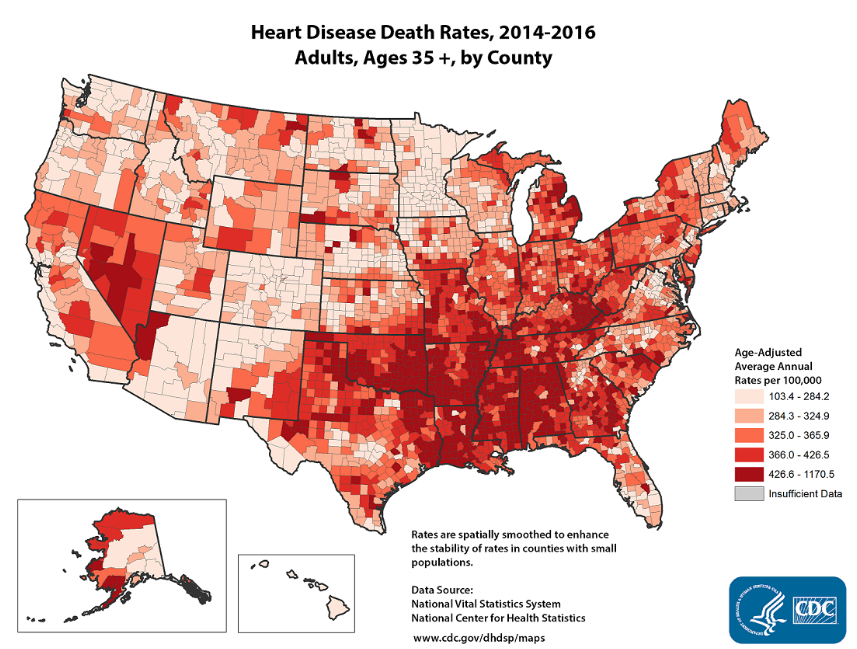

In [12]:
Image("Heart_disease_deaths_map.png")

#### We wanted to look at which were the states in 2014, which still had high mortality rates for Cardiovascular diseases. So, we looked at the Top 3 states – They were Mississippi, Arkansas and Oklahoma. We wanted to look at how these states were performing in terms of all the other disease categories as well, other than Cardiovascular. Hence, we plotted a graph with a % change in mortality rate between two timeframes – 1980 and 2014 for all the 21 disease categories. We found one particular trend in all the 3 states. There was a sharp increase in percent change of mortality for Mental Health & Substance abuse related deaths in each of these states. This made us curious whether this was a trend only in these 3 states or was it everywhere. The following 3 images walk through this analysis.

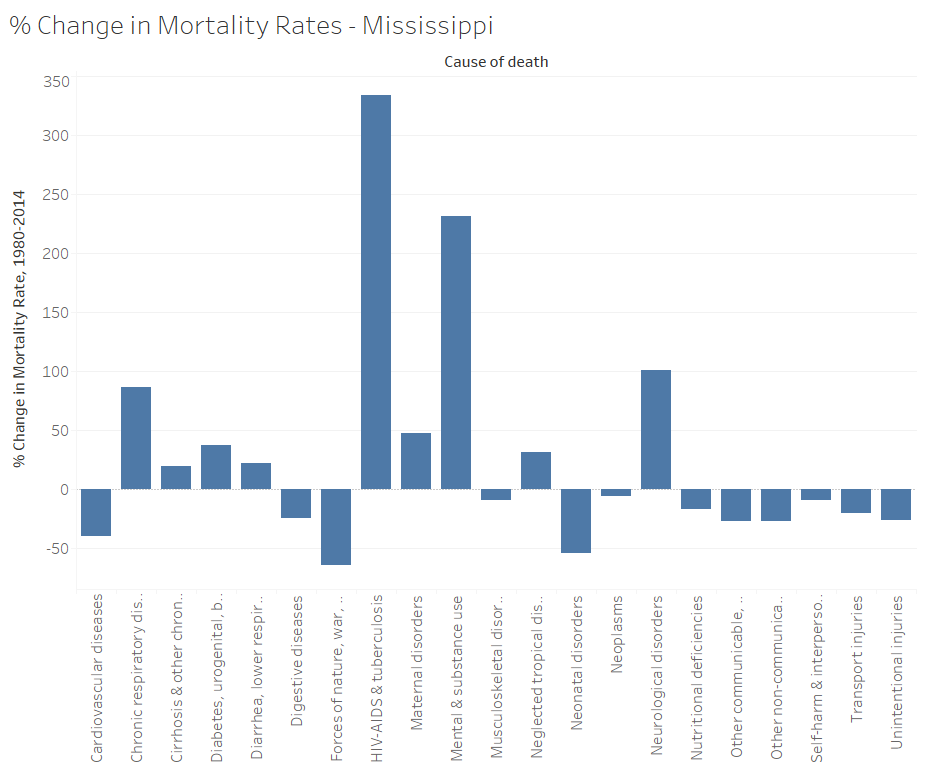

In [13]:
Image("Mississippi_Pct_Change.png")

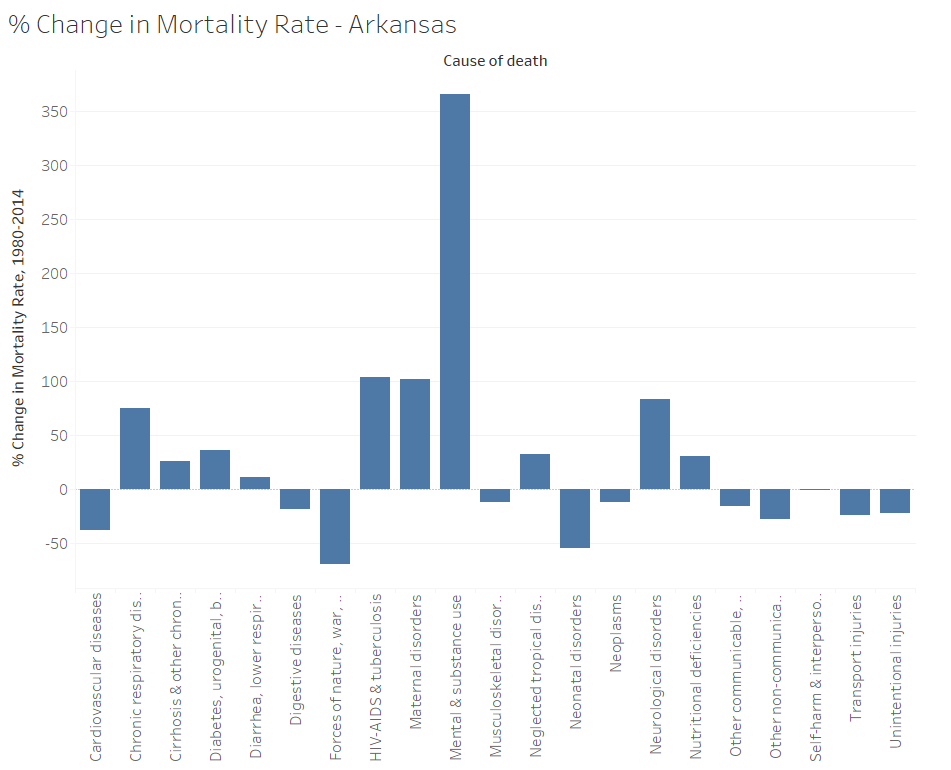

In [14]:
Image("Arkansas_Pct_Change.png")

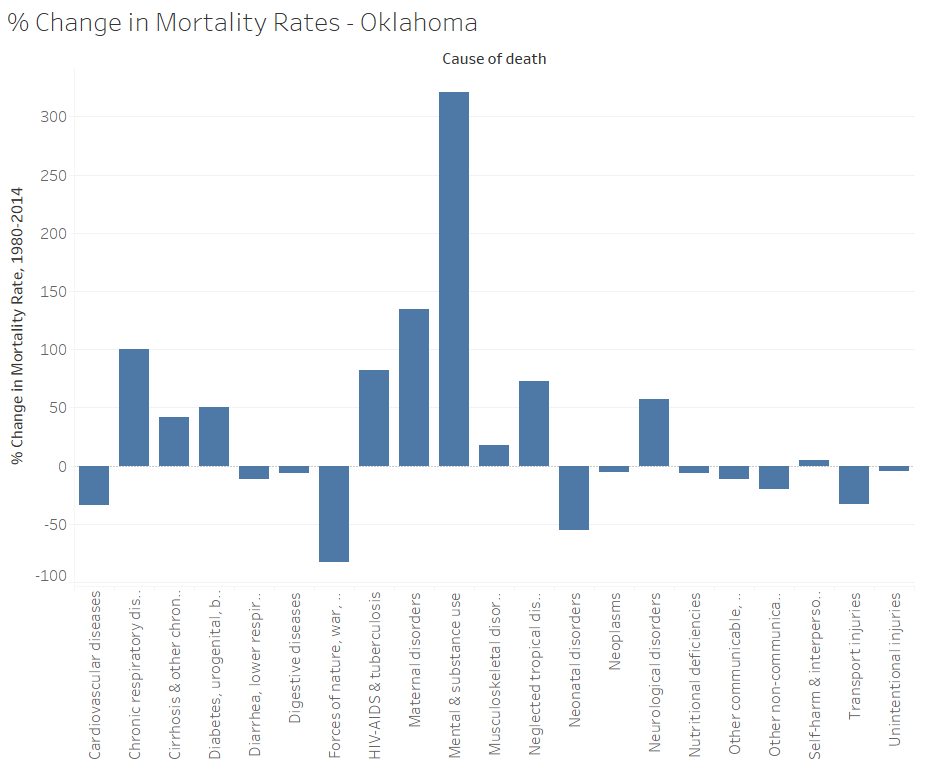

In [15]:
Image("Oklahoma_Pct_Change.png")

#### In order to check whether that was the trend overall, we created a time-lapse visualization of a US Map and to see how mortality rates for Mental & Substance abuse have changed across different US states from 1980 to 2014 for each 5 year period gap. Below is the video for that. The lighter colors indicate that the mortality rate was low, and darker colors indicate that it was high. The range is mentioned in the legend of the graph.

In [16]:
Video("Mental_Health_Time_Lapse.mp4", width = 1000)

#### As you can see, the map gets darker with time and it is evident that the situation has worsened across all the states for Mental & Substance abuse related deaths. Particularly, states like New Mexico, Alaska and West Virginia seem to have the highest impact as their color shade is darker compared to other in 2014. We wanted to dig deeper whether these deaths were happening at the same scale all across the state or these states faced this issue only in certain pockets. Hence, we decided to do a county level analysis for these states.

#### When we looked at county level, we found out that the mental and substance abuse related mortality was definitely bad across the state, but it was significantly worse in one particular county named ‘Rio Arriba County’ in the northern part of New Mexico. Rather it was the highest in the entire US. Searching online, we found that this Rio Arriba has a severe opioid crisis going on, and it deals with poverty and high-criminality. This shows us why and how poverty, drug abuse and crime are often correlated.

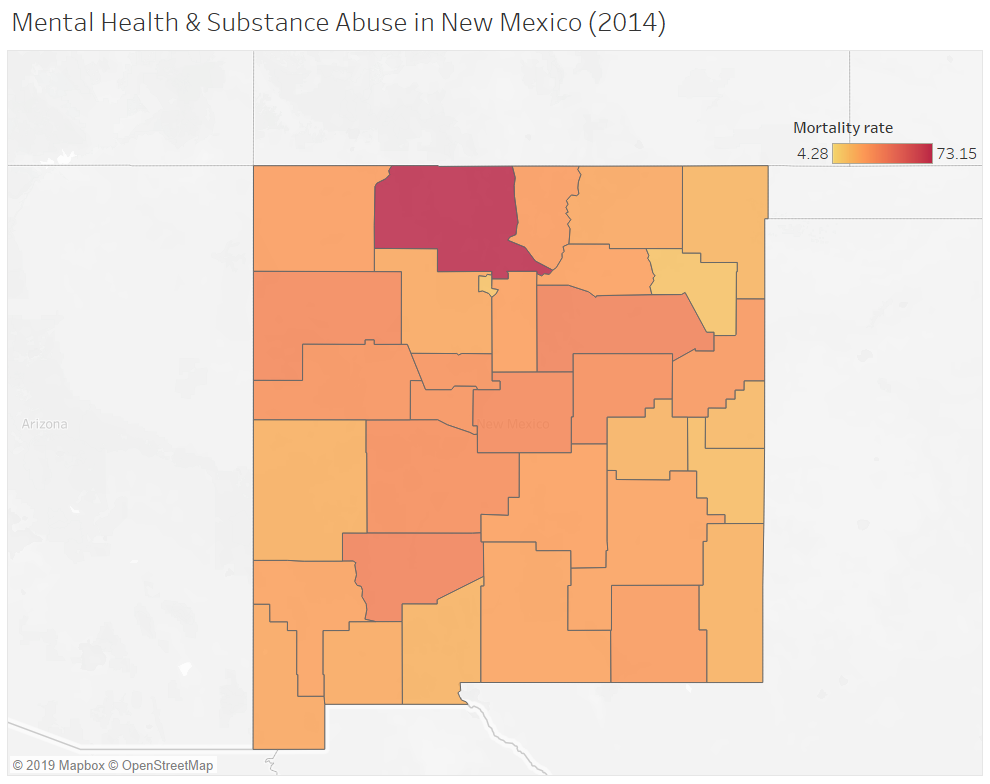

In [17]:
Image("New_Mexico_MentalHealth.png")

#### Even for West Virginia and Alaska, it was observed that there was disparity at county level in terms of mortality rates. There were certain counties that were significantly performing worse than others.

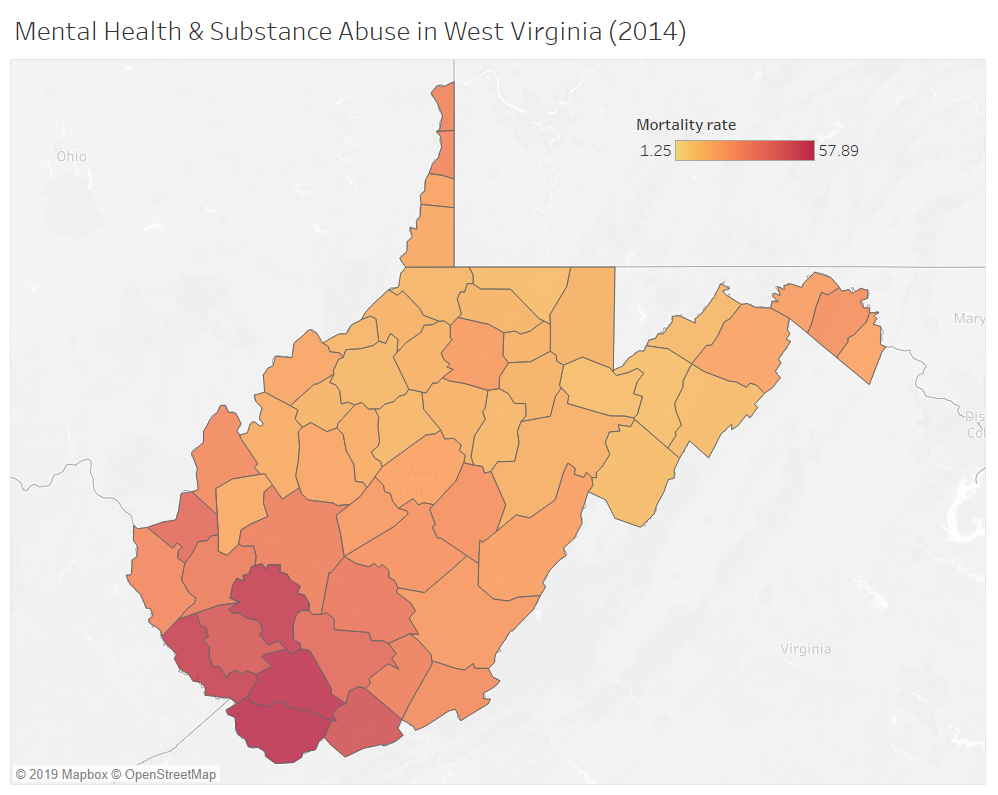

In [18]:
Image("West_Virginia_Mental_Health.png")

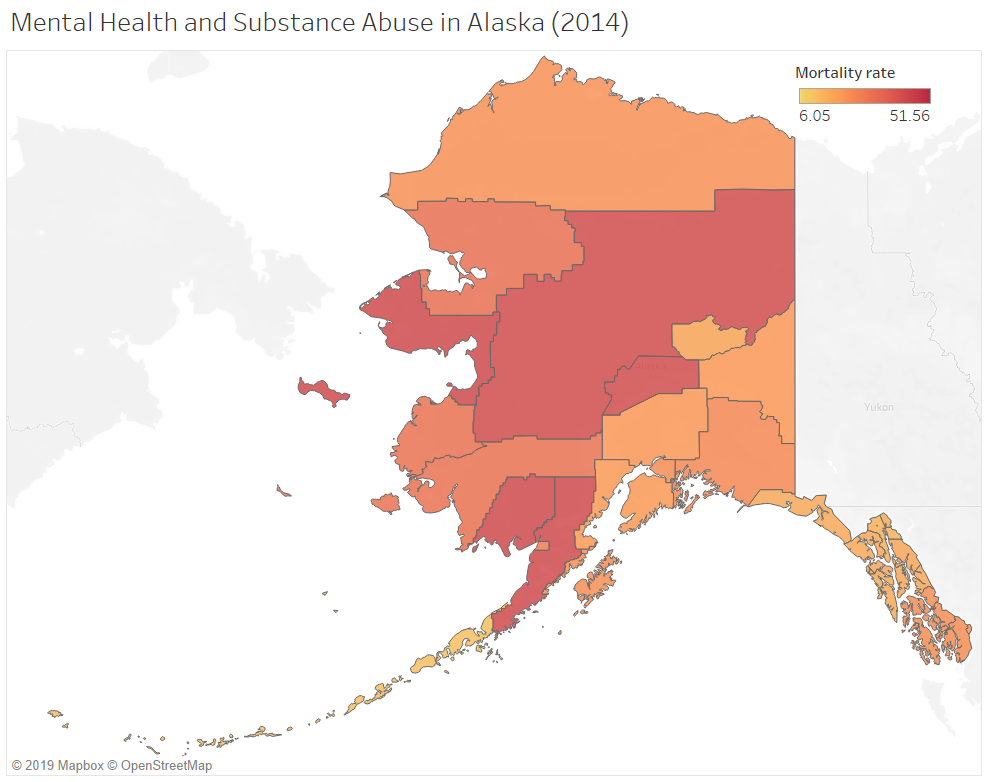

In [19]:
Image("Alaska_MentalHealth.png")

#### Additional Analysis that did not make into the powerpoint presentation: Looking at Transportation-related Deaths

#### The attached article (https://www.citylab.com/transportation/2013/02/4-reasons-us-trails-world-road-safety/4608/) prompted us to look at how US is performing in terms of Transport related deaths over last couple of years. We found out that most of the states, barring a few, have been able to bring down the mortality rates for Transport related deaths. One of the worst performing state in that regard is Mississippi, which has continuously had high mortality due to transport related deaths.

In [20]:
HTML("""'<iframe width="560" height="315" src="https://www.youtube.com/embed/NhjIcl-qvCM"
          frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" 
          allowfullscreen></iframe>'
     """)

#### This graph shows the top 10 highest mortality states for transport related injuries and it can be observed that Alaska was the worst performing one in 1980, and it has significantly changed over the time and in 2014, Alaska is lower than the other 9 states.

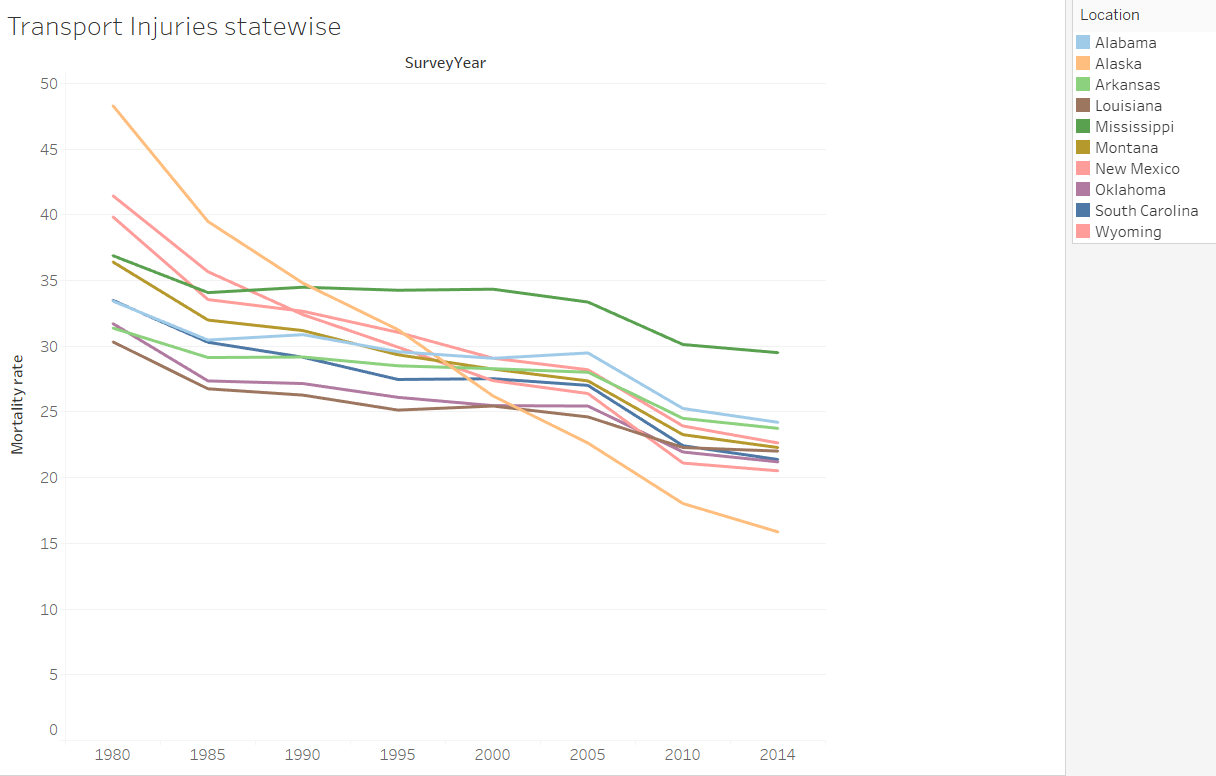

In [21]:
Image("Transport_Deaths_Statewise.png")

## Concluding Remarks
#### Overall, our analysis sheds light on the fact that there is great variation on how even a single disease can impact people across states, and as if not more importantly, across counties. This variation in impacts from diseases suggests that policy should also vary at a more local level. While much focus is placed by policy makers to tackle this problem at the federal level, it may serve them well to also focus on more local approaches to healthcare policy.